# Statistical study of cosmological friction and its effect on the redshift vs inferred chirp-mass relation of gravitational waves

* This is in reference to the [paper](https://arxiv.org/pdf/2309.03833.pdf)

* From the paper equation 2.13, we have the following equations for the effect of cosmological friction on the luminosity distance of gravitational waves:

$$ d^{GW}_{L}(z) = d^{EM}_{L}(z) \exp \left\{ \frac{c_M}{2 \Omega_{\Lambda,0}} \ln \left[ \frac{1+z}{(\Omega_{m,0}(1+z)^3 + \Omega_{\Lambda,0})^{1/3}} \right] \right\} $$

* This represents the relation between the gravitational wave (GW) luminosity distance and the electromagnetic (EM) luminosity distance, taking into account the cosmological parameters for matter $\Omega_{m,0}$ and dark energy $\Omega_{\Lambda,0}$, along with a redshift $z$ and a constant $c_M$.

* The goal is to study the effect of the cosmological friction term on the luminosity distance of gravitational waves and how it affects the inferred chirp-mass of the gravitational wave source.

In [2]:
from astropy.cosmology import LambdaCDM
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from ler.rates import LeR
from ler.utils import get_param_from_json

## Function to convert from luminosity distance to redshift

In [5]:
# let's set up interpolation for with scipy
# conversion from luminosity distance to redshift
from ler.utils import  interpolator_from_json, cubic_spline_interpolator
from numba import njit

# the follwoing code is to create a spline interpolation
# the interpolation is saved in a pickle file for later use
# the interpolation function is njited for faster computation
z_max = 10
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
dL = lambda z_: cosmo.luminosity_distance(z_).to(u.Mpc).value  # luminosity distance in Mpc
resolution = 1000
create_new = False  # important 
spline_dL = interpolator_from_json(
    identifier_dict= dict(z_min=0.001, z_max=z_max, cosmology=cosmo, resolution=resolution),
    directory='interpolator_json',
    sub_directory="dL_to_z", 
    name="dL_to_z",
    x = np.geomspace(0.001, z_max, resolution),
    pdf_func= dL, 
    conditioned_y=None,
    dimension=1,
    category="function_inverse",
    create_new= create_new,
)
dL_to_z = njit(lambda dL_: cubic_spline_interpolator(dL_, spline_dL[0], spline_dL[1]))

dL_to_z interpolator will be loaded from interpolator_json/dL_to_z/dL_to_z_0.pickle


In [6]:
# test
z = 1
d_L = cosmo.luminosity_distance(z).to(u.Mpc).value
dL_to_z(np.array([d_L]))

array([1.])

## Functional form of change in the luminosity distance due to cosmological friction

In [6]:
# here I have consider dL=dL_EM=dL_GW at CM=0; no cosmological friction.
Ode0 = cosmo.Ode0  # dark energy density
Om0 = cosmo.Om0  # matter density

@njit
def dL_GW_CM(dL, CM=0):    
    
    # Compute the GW luminosity distance using the formula
    dL_GW = dL * np.exp(CM / (2 * Ode0) * 
                           np.log((1 + z) / (Om0 * (1 + z)**3 + Ode0)**(1/3)))
    
    return dL_GW

In [7]:
# test
dL = np.array([1000])
dL_GW_CM(dL=dL, CM=2)

array([1570.58372199])

## BBH events (O4 sensitivity)

* `ler` initialization

In [8]:
ler = LeR(verbose=False)

interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [02:35<00:00,  3.11s/it]


* sample GW source parameters

In [10]:
ler.batch_size = 100000
unlensed_param = ler.unlensed_cbc_statistics(size=500000, output_jsonfile='unlensed_param.json', resume=False);

unlensed params will be store in ./ler_data/unlensed_param.json
chosen batch size = 100000 with total size = 500000
There will be 5 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
Batch no. 2
sampling gw source params...
calculating snrs...
Batch no. 3
sampling gw source params...
calculating snrs...
Batch no. 4
sampling gw source params...
calculating snrs...
Batch no. 5
sampling gw source params...
calculating snrs...
saving all unlensed_params in ./ler_data/unlensed_param.json...


* let's consider three cases: CM = 0, -1, 2

* replace the luminosity distance with the one that includes the cosmological friction term

In [17]:
new_dL_cm_m1 = dL_GW_CM(dL=unlensed_param['luminosity_distance'], CM=-1)
new_dL_cm_2 = dL_GW_CM(dL=unlensed_param['luminosity_distance'], CM=2)

# new luminosity distance
unlensed_param_cm_0 = unlensed_param.copy()
unlensed_param_cm_m1 = unlensed_param.copy()
unlensed_param_cm_m1['luminosity_distance'] = new_dL_cm_m1
unlensed_param_cm_2 = unlensed_param.copy()
unlensed_param_cm_2['luminosity_distance'] = new_dL_cm_2

# new snrs
snr_cm_m1 = ler.snr(gw_param_dict=unlensed_param_cm_m1)
snr_cm_2 = ler.snr(gw_param_dict=unlensed_param_cm_2)
unlensed_param_cm_m1.update(snr_cm_m1)
unlensed_param_cm_2.update(snr_cm_2)

### rates of detectable events per year

In [18]:
# CM = 0
_, unlensed_param_cm_0_det = ler.unlensed_rate(
    unlensed_param=unlensed_param_cm_0, 
    output_jsonfile='unlensed_param_cm_0_det.json'
    )

using provided unlensed_param dict...
given detectability_condition == 'step_function'
total unlensed rate (yr^-1) (with step function): 441.8357225693884
number of simulated unlensed detectable events: 2134
number of all simulated unlensed events: 500000
storing detectable unlensed params in ./ler_data/unlensed_param_cm_0_det.json


In [19]:
# CM = -1
_, unlensed_param_cm_m1_det = ler.unlensed_rate(
    unlensed_param=unlensed_param_cm_m1, 
    output_jsonfile='unlensed_param_cm_m1_det.json'
    )

using provided unlensed_param dict...
given detectability_condition == 'step_function'
total unlensed rate (yr^-1) (with step function): 856.9625378231952
number of simulated unlensed detectable events: 4139
number of all simulated unlensed events: 500000
storing detectable unlensed params in ./ler_data/unlensed_param_cm_m1_det.json


In [20]:
# CM = 2
_, unlensed_param_cm_2_det = ler.unlensed_rate(
    unlensed_param=unlensed_param_cm_2, 
    output_jsonfile='unlensed_param_cm_2_det.json'
    )

using provided unlensed_param dict...
given detectability_condition == 'step_function'
total unlensed rate (yr^-1) (with step function): 112.63291147035956
number of simulated unlensed detectable events: 544
number of all simulated unlensed events: 500000
storing detectable unlensed params in ./ler_data/unlensed_param_cm_2_det.json


* there is significant difference in the rates of detectable events per year for the three cases

### redshifts plot

In [ ]:
# getting param from json file
# uncomment the following lines to get the parameters from the json file
# unlensed_param_cm_0 = get_param_from_json("ler_data/unlensed_param_cm_0_det.json")
# unlensed_param_cm_m1 = get_param_from_json("ler_data/unlensed_param_cm_m1_det.json")
# unlensed_param_cm_2 = get_param_from_json("ler_data/unlensed_param_cm_2_det.json")

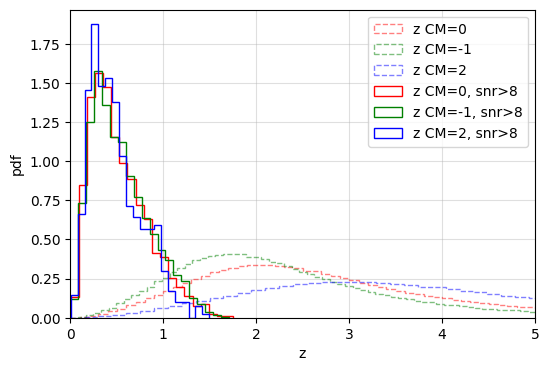

In [21]:
z1 = dL_to_z(unlensed_param_cm_0['luminosity_distance'])
z2 = dL_to_z(unlensed_param_cm_m1['luminosity_distance'])
z3 = dL_to_z(unlensed_param_cm_2['luminosity_distance'])
z1_det = dL_to_z(unlensed_param_cm_0_det['luminosity_distance'])
z2_det = dL_to_z(unlensed_param_cm_m1_det['luminosity_distance'])
z3_det = dL_to_z(unlensed_param_cm_2_det['luminosity_distance'])

plt.figure(figsize=(6, 4))
plt.hist(z1, bins=100, histtype='step', label='z CM=0', density=True, color='r', linestyle='--', alpha=0.5)
plt.hist(z2, bins=100, histtype='step', label='z CM=-1', density=True, color='g', linestyle='--', alpha=0.5)
plt.hist(z3, bins=100, histtype='step', label='z CM=2', density=True, color='b', linestyle='--', alpha=0.5)
plt.hist(z1_det, bins=20, histtype='step', label='z CM=0, snr>8', density=True, color='r', linestyle='-', alpha=1)
plt.hist(z2_det, bins=20, histtype='step', label='z CM=-1, snr>8', density=True, color='g', linestyle='-', alpha=1)
plt.hist(z3_det, bins=20, histtype='step', label='z CM=2, snr>8', density=True, color='b', linestyle='-', alpha=1)
plt.legend()
plt.xlabel('z')
plt.ylabel('pdf')
plt.xlim(0, 5)
plt.grid(alpha=0.4)
plt.show()

* redshift distribution almost the same, the detectability is limited by the sensitivity of the detector

## Inferred source chirp-mass vs redshift

* detectable cases only

* inferred source $\mathcal{M}_c=\mathcal{M}_c^{obs} / (1+z_s^{obs}$)

In [22]:
# getting param from json file
# unlensed_param_cm_0 = get_param_from_json("ler_data/unlensed_param_cm_0_det.json")
# unlensed_param_cm_m1 = get_param_from_json("ler_data/unlensed_param_cm_m1_det.json")
# unlensed_param_cm_2 = get_param_from_json("ler_data/unlensed_param_cm_2_det.json")

* for CM = 0

In [23]:
# detector frame masses
m1_cm_0 = np.array(unlensed_param_cm_0['mass_1'])
m2_cm_0 = np.array(unlensed_param_cm_0['mass_2'])
# chirp mass
mc_cm_0 = (m1_cm_0*m2_cm_0)**(3/5)/(m1_cm_0+m2_cm_0)**(1/5)

# redshifts
dl_cm_0 = np.array(unlensed_param_cm_0['luminosity_distance'])
z_cm_0 = dL_to_z(dl_cm_0)

# inferred chirp mass
mc_inferred_cm_0 = mc_cm_0/(1+z_cm_0)

* for CM = -1

In [24]:
# detector frame masses
m1_cm_m1 = np.array(unlensed_param_cm_m1['mass_1'])
m2_cm_m1 = np.array(unlensed_param_cm_m1['mass_2'])
# chirp mass
mc_cm_m1 = (m1_cm_m1*m2_cm_m1)**(3/5)/(m1_cm_m1+m2_cm_m1)**(1/5)

# redshifts
dl_cm_m1 = np.array(unlensed_param_cm_m1['luminosity_distance'])
z_cm_m1 = dL_to_z(dl_cm_m1)

# inferred chirp mass
mc_inferred_cm_m1 = mc_cm_m1/(1+z_cm_m1)

* for CM = 2

In [25]:
# detector frame masses
m1_cm_2 = np.array(unlensed_param_cm_2['mass_1'])
m2_cm_2 = np.array(unlensed_param_cm_2['mass_2'])
# chirp mass
mc_cm_2 = (m1_cm_2*m2_cm_2)**(3/5)/(m1_cm_2+m2_cm_2)**(1/5)

# redshifts
dl_cm_2 = np.array(unlensed_param_cm_2['luminosity_distance'])
z_cm_2 = dL_to_z(dl_cm_2)

# inferred chirp mass
mc_inferred_cm_2 = mc_cm_2/(1+z_cm_2)

### Contour plot of the inferred chirp-mass vs redshift

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [27]:
# cm_0
# Assuming your data is loaded and you have mass, redshift arrays
# Replace these with your actual data arrays
mass = mc_inferred_cm_0  # Your mass data
redshift = z_cm_0  # Your redshift data

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels = np.percentile(kde, [10, 30, 50, 70, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X1, Y1 = np.meshgrid(xgrid, ygrid)
Z1 = gaussian_kde(xy)(np.vstack([X1.ravel(), Y1.ravel()])).reshape(X1.shape)

In [28]:
# cm_2
# Assuming your data is loaded and you have mass, redshift arrays
# Replace these with your actual data arrays
mass = mc_inferred_cm_2  # Your mass data
redshift = z_cm_2  # Your redshift data

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels = np.percentile(kde, [10, 30, 50, 70, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X2, Y2 = np.meshgrid(xgrid, ygrid)
Z2 = gaussian_kde(xy)(np.vstack([X2.ravel(), Y2.ravel()])).reshape(X2.shape)

In [29]:
# cm_m1
# Assuming your data is loaded and you have mass, redshift arrays
# Replace these with your actual data arrays
mass = mc_inferred_cm_m1  # Your mass data
redshift = z_cm_m1  # Your redshift data

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels = np.percentile(kde, [10, 30, 50, 70, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X3, Y3 = np.meshgrid(xgrid, ygrid)
Z3 = gaussian_kde(xy)(np.vstack([X3.ravel(), Y3.ravel()])).reshape(X3.shape)


INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode


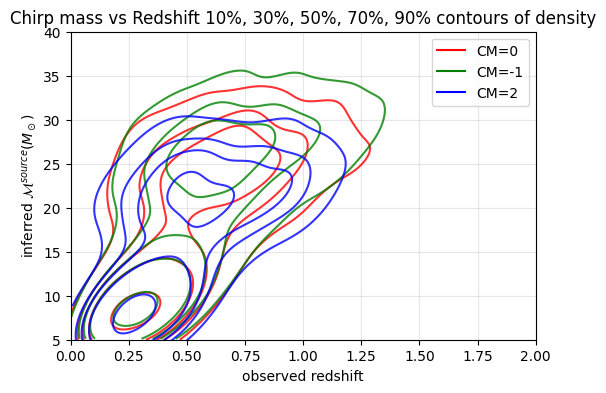

In [35]:
# Plotting
plt.figure(figsize=(6, 4))
plt.contour(X1, Y1, Z1, levels=levels, colors=['red', 'red', 'red', 'red', 'red'], alpha=0.8)
plt.contour(X3, Y3, Z3, levels=levels, colors=['green', 'green', 'green', 'green', 'green'], alpha=0.8)
plt.contour(X2, Y2, Z2, levels=levels, colors=['blue', 'blue', 'blue', 'blue', 'blue'], alpha=0.8)
plt.xlabel("observed redshift")
plt.ylabel(r"inferred $\mathcal{M}^{source} (M_\odot)$")
plt.title("Chirp mass vs Redshift 10%, 30%, 50%, 70%, 90% contours of density")
# plt.colorbar(contour1, label='Density')
plt.xlim(0, 2.0)
plt.ylim(5, 40)
plt.grid(alpha=0.3)
# Add legend
# Create proxy artists for legend
proxy1 = plt.Line2D([0], [0], linestyle='-', color='red', label='CM=0')
proxy3 = plt.Line2D([0], [0], linestyle='-', color='green', label='CM=-1')
proxy2 = plt.Line2D([0], [0], linestyle='-', color='blue', label='CM=2')
plt.legend(handles=[proxy1, proxy3, proxy2], loc='upper right')
plt.show()

* This plot shows no significant shift in the plots

* The plot is much different from effect caused by lensed events, as shown below. So we don't expect significant degeneracy between the two effects, in O4 sensitivity.

<p align="center">
  <img src="mc_vs_zs_2img.png" alt="zs" width="60%">
</p>


* Let's look at the chirp mass only 

### Looking for outlier in the inferred chirp mass distribution

In [36]:
# create cdf function of mc_source_eff_ distribution
def cdf(data):
    """ Cumulative distribution function of a 1D array """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return x, y

x_cm_0, y_cm_0 = cdf(mc_inferred_cm_0)
x_cm_m1, y_cm_m1 = cdf(mc_inferred_cm_m1)
x_cm_2, y_cm_2 = cdf(mc_inferred_cm_2)

<Figure size 600x400 with 0 Axes>

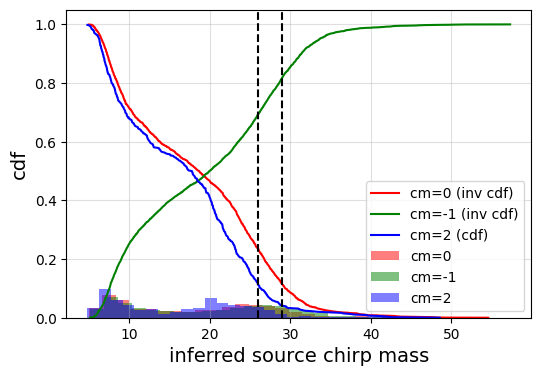

In [46]:
# plot
plt.figure(figsize=(6, 4))
plt.figure(figsize=(6,4))
plt.plot(x_cm_0, 1-y_cm_0, label='cm=0 (inv cdf)', color='r')
plt.plot(x_cm_m1, y_cm_m1, label='cm=-1 (inv cdf)', color='g')
plt.plot(x_cm_2, 1-y_cm_2, label='cm=2 (cdf)', color='b')
plt.hist(mc_inferred_cm_0, bins=30, density=True, alpha=0.5, label='cm=0', color='r')
plt.hist(mc_inferred_cm_m1, bins=30, density=True, alpha=0.5, label='cm=-1', color='g')
plt.hist(mc_inferred_cm_2, bins=30, density=True, alpha=0.5, label='cm=2', color='b')
plt.xlabel("inferred source chirp mass", fontsize=14)
plt.ylabel("cdf", fontsize=14)
plt.legend()
plt.grid(alpha=0.4)
# include a vertical line at 25
plt.axvline(29, color='k', linestyle='--')
plt.axvline(26, color='k', linestyle='--')
plt.show()

* outside 90% of cm=0 distribution, 15% of CM=-1 distribution lie beyond, and thus inferring a higher chirp mass for CM=-1
* outside 90% of cm=2 distribution, 20% of cm=0 distribution lie beyond, and thus inferring a lower chirp mass for CM=2

## BBH (3G sensitivities)

* let's do the same for 3G sensitivity 

In [57]:
ler = LeR(batch_size=100000, ifos=['CE', 'ET'], verbose=False)

In [58]:
unlensed_param = ler.unlensed_cbc_statistics(size=500000, output_jsonfile='unlensed_param_3G_cosmo.json', resume=False);

unlensed params will be store in ./ler_data/unlensed_param_3G_cosmo.json
chosen batch size = 100000 with total size = 500000
There will be 5 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
Batch no. 2
sampling gw source params...
calculating snrs...
Batch no. 3
sampling gw source params...
calculating snrs...
Batch no. 4
sampling gw source params...
calculating snrs...
Batch no. 5
sampling gw source params...
calculating snrs...
saving all unlensed_params in ./ler_data/unlensed_param_3G_cosmo.json...


In [59]:
new_dL_cm_m1 = dL_GW_CM(dL=unlensed_param['luminosity_distance'], CM=-1)
new_dL_cm_2 = dL_GW_CM(dL=unlensed_param['luminosity_distance'], CM=2)

# new luminosity distance
unlensed_param_cm_0 = unlensed_param.copy()
unlensed_param_cm_m1 = unlensed_param.copy()
unlensed_param_cm_m1['luminosity_distance'] = new_dL_cm_m1
unlensed_param_cm_2 = unlensed_param.copy()
unlensed_param_cm_2['luminosity_distance'] = new_dL_cm_2

# new snrs
snr_cm_m1 = ler.snr(gw_param_dict=unlensed_param_cm_m1)
snr_cm_2 = ler.snr(gw_param_dict=unlensed_param_cm_2)
unlensed_param_cm_m1.update(snr_cm_m1)
unlensed_param_cm_2.update(snr_cm_2)

In [60]:
# CM = 0
_, unlensed_param_cm_0_det = ler.unlensed_rate(
    unlensed_param=unlensed_param_cm_0, 
    output_jsonfile='unlensed_param_cm_0_det.json'
    )

using provided unlensed_param dict...
given detectability_condition == 'step_function'
total unlensed rate (yr^-1) (with step function): 91937.23512506043
number of simulated unlensed detectable events: 444043
number of all simulated unlensed events: 500000
storing detectable unlensed params in ./ler_data/unlensed_param_cm_0_det.json


In [61]:
# CM = -1
_, unlensed_param_cm_m1_det = ler.unlensed_rate(
    unlensed_param=unlensed_param_cm_m1, 
    output_jsonfile='unlensed_param_cm_m1_det.json'
    )

using provided unlensed_param dict...
given detectability_condition == 'step_function'
total unlensed rate (yr^-1) (with step function): 93944.75113538507
number of simulated unlensed detectable events: 453739
number of all simulated unlensed events: 500000
storing detectable unlensed params in ./ler_data/unlensed_param_cm_m1_det.json


In [62]:
# CM = 2
_, unlensed_param_cm_2_det = ler.unlensed_rate(
    unlensed_param=unlensed_param_cm_2, 
    output_jsonfile='unlensed_param_cm_2_det.json'
    )

using provided unlensed_param dict...
given detectability_condition == 'step_function'
total unlensed rate (yr^-1) (with step function): 82931.36426067396
number of simulated unlensed detectable events: 400546
number of all simulated unlensed events: 500000
storing detectable unlensed params in ./ler_data/unlensed_param_cm_2_det.json


### redshifts plot

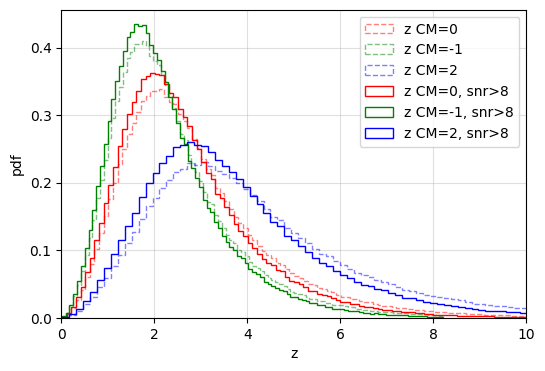

In [63]:
z1 = dL_to_z(unlensed_param_cm_0['luminosity_distance'])
z2 = dL_to_z(unlensed_param_cm_m1['luminosity_distance'])
z3 = dL_to_z(unlensed_param_cm_2['luminosity_distance'])
z1_det = dL_to_z(unlensed_param_cm_0_det['luminosity_distance'])
z2_det = dL_to_z(unlensed_param_cm_m1_det['luminosity_distance'])
z3_det = dL_to_z(unlensed_param_cm_2_det['luminosity_distance'])

plt.figure(figsize=(6, 4))
plt.hist(z1, bins=100, histtype='step', label='z CM=0', density=True, color='r', linestyle='--', alpha=0.5)
plt.hist(z2, bins=100, histtype='step', label='z CM=-1', density=True, color='g', linestyle='--', alpha=0.5)
plt.hist(z3, bins=100, histtype='step', label='z CM=2', density=True, color='b', linestyle='--', alpha=0.5)
plt.hist(z1_det, bins=100, histtype='step', label='z CM=0, snr>8', density=True, color='r', linestyle='-', alpha=1)
plt.hist(z2_det, bins=100, histtype='step', label='z CM=-1, snr>8', density=True, color='g', linestyle='-', alpha=1)
plt.hist(z3_det, bins=100, histtype='step', label='z CM=2, snr>8', density=True, color='b', linestyle='-', alpha=1)
plt.legend()
plt.xlabel('z')
plt.ylabel('pdf')
plt.xlim(0, 10)
plt.grid(alpha=0.4)
plt.show()

* now the detectable redshifts are much different for the three cases

### Contour plot of the inferred chirp-mass vs redshift

In [3]:
# getting param from json file
# unlensed_param_cm_0 = get_param_from_json("ler_data/unlensed_param_cm_0_det.json")
# unlensed_param_cm_m1 = get_param_from_json("ler_data/unlensed_param_cm_m1_det.json")
# unlensed_param_cm_2 = get_param_from_json("ler_data/unlensed_param_cm_2_det.json")

In [7]:
# CM = 0
# detector frame masses
m1_cm_0 = np.array(unlensed_param_cm_0['mass_1'])
m2_cm_0 = np.array(unlensed_param_cm_0['mass_2'])
# chirp mass
mc_cm_0 = (m1_cm_0*m2_cm_0)**(3/5)/(m1_cm_0+m2_cm_0)**(1/5)

# redshifts
dl_cm_0 = np.array(unlensed_param_cm_0['luminosity_distance'])
z_cm_0 = dL_to_z(dl_cm_0)

# inferred chirp mass
mc_inferred_cm_0 = mc_cm_0/(1+z_cm_0)

# CM = -1
# detector frame masses
m1_cm_m1 = np.array(unlensed_param_cm_m1['mass_1'])
m2_cm_m1 = np.array(unlensed_param_cm_m1['mass_2'])
# chirp mass
mc_cm_m1 = (m1_cm_m1*m2_cm_m1)**(3/5)/(m1_cm_m1+m2_cm_m1)**(1/5)

# redshifts
dl_cm_m1 = np.array(unlensed_param_cm_m1['luminosity_distance'])
z_cm_m1 = dL_to_z(dl_cm_m1)

# inferred chirp mass
mc_inferred_cm_m1 = mc_cm_m1/(1+z_cm_m1)

# CM = 2
# detector frame masses
m1_cm_2 = np.array(unlensed_param_cm_2['mass_1'])
m2_cm_2 = np.array(unlensed_param_cm_2['mass_2'])
# chirp mass
mc_cm_2 = (m1_cm_2*m2_cm_2)**(3/5)/(m1_cm_2+m2_cm_2)**(1/5)

# redshifts
dl_cm_2 = np.array(unlensed_param_cm_2['luminosity_distance'])
z_cm_2 = dL_to_z(dl_cm_2)

# inferred chirp mass
mc_inferred_cm_2 = mc_cm_2/(1+z_cm_2)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [11]:
# cm_0
# Assuming your data is loaded and you have mass, redshift arrays
# Replace these with your actual data arrays
mass = mc_inferred_cm_0[0:5000]  # Your mass data
redshift = z_cm_0[0:5000]  # Your redshift data

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels = np.percentile(kde, [10, 30, 50, 70, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X1, Y1 = np.meshgrid(xgrid, ygrid)
Z1 = gaussian_kde(xy)(np.vstack([X1.ravel(), Y1.ravel()])).reshape(X1.shape)

In [12]:
# cm_2
# Assuming your data is loaded and you have mass, redshift arrays
# Replace these with your actual data arrays
mass = mc_inferred_cm_2[0:5000]  # Your mass data
redshift = z_cm_2[0:5000]  # Your redshift data

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels = np.percentile(kde, [10, 30, 50, 70, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X2, Y2 = np.meshgrid(xgrid, ygrid)
Z2 = gaussian_kde(xy)(np.vstack([X2.ravel(), Y2.ravel()])).reshape(X2.shape)

In [13]:
# cm_m1
# Assuming your data is loaded and you have mass, redshift arrays
# Replace these with your actual data arrays
mass = mc_inferred_cm_m1[0:5000]  # Your mass data
redshift = z_cm_m1[0:5000]  # Your redshift data

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels = np.percentile(kde, [10, 30, 50, 70, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X3, Y3 = np.meshgrid(xgrid, ygrid)
Z3 = gaussian_kde(xy)(np.vstack([X3.ravel(), Y3.ravel()])).reshape(X3.shape)

INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode


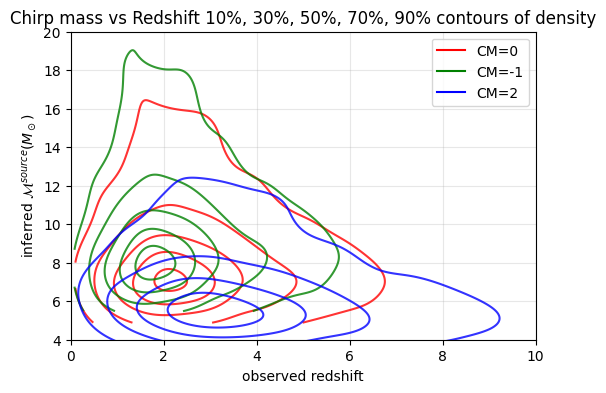

In [17]:
# Plotting
plt.figure(figsize=(6, 4))
plt.contour(X1, Y1, Z1, levels=levels, colors=['red', 'red', 'red', 'red', 'red'], alpha=0.8)
plt.contour(X3, Y3, Z3, levels=levels, colors=['green', 'green', 'green', 'green', 'green'], alpha=0.8)
plt.contour(X2, Y2, Z2, levels=levels, colors=['blue', 'blue', 'blue', 'blue', 'blue'], alpha=0.8)
plt.xlabel("observed redshift")
plt.ylabel(r"inferred $\mathcal{M}^{source} (M_\odot)$")
plt.title("Chirp mass vs Redshift 10%, 30%, 50%, 70%, 90% contours of density")
# plt.colorbar(contour1, label='Density')
plt.xlim(0, 10.0)
plt.ylim(4, 20)
plt.grid(alpha=0.3)
# Add legend
# Create proxy artists for legend
proxy1 = plt.Line2D([0], [0], linestyle='-', color='red', label='CM=0')
proxy3 = plt.Line2D([0], [0], linestyle='-', color='green', label='CM=-1')
proxy2 = plt.Line2D([0], [0], linestyle='-', color='blue', label='CM=2')
plt.legend(handles=[proxy1, proxy3, proxy2], loc='upper right')
plt.show()

* For CM = -1, it significantly overestimates the chirp mass
* For CM = 2, it significantly underestimates the chirp mass

**Conclusion :** The effect of cosmological friction on the redshift vs inferred chirp-mass relation of gravitational waves should be prominent just by comparing high redshift events with low redshift events.

**Note 1:** For low chirp mass high redshift events in CM=2, it can have degeneracies if primordial black holes are considered.

**Note 2:** For high chirp mass low redshift events in CM=-1, it can have degeneracies with lensing events.


## Rates of detectable events per year

| CM | Rate (O4) | Rate (3G) |
|----|-----------|-----------|
| 0  | 441       | 91937     |
| -1 | 857       | 93944     |
| 2  | 113       | 82931     |

* Rate differences are expected to be more prominent in O4 sensitivities.